# Correlation(difference(belief - eye), neural activity)

we want to find where belief and eye differs, and see if the difference is encoded by neural activity.

eg, when eb differ, neural has another pattern.  
eg, neural correlate to eb difference (this difference can be a cross feature)

what do we do?  
1, manual design some feature and see if there is correlation. by correlation number, and by visualization in embedding space.  
2, select the time when they differ and neural corr to diff more. we should select based on task var, not the difference directly? 

# outline
- manual feature. measure the b-e difference
    - simple difference and difference squared.
    - stats. quickly check if neural corr to the diff.
        - single var. single neuron corr to diff.
        - multi var. neural embedding corr to diff.
    - visualization. the diff has a gradient in embedding space.

- (todo) selection. focus on when b-e have difference. since the diff is there obvisouly, pause for now.
    - inter trial interval varification.

### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
# import
from scipy.stats import spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression

from neural_plot_ult import *
from matplotlib import pyplot as plt
import numpy as np
import cebra
from cebra import CEBRA
import pandas as pd
import tempfile
from pathlib import Path
import sys
import os
import pickle
from pathlib import Path

In [4]:

import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [5]:

from notification import notify

In [6]:
datafile='0404normzica.nbedata'
embeddingfile='0404normzica_0404.pt'

In [7]:
# real data
with open(f'{workdir}/test/neural/cebra/{datafile}', 'rb') as f:
    (neural_data, continuous_label, var_names) = pickle.load(f)

var_names

['sess_latentff_hori',
 'sess_latentff_vert',
 'sess_eye_hori',
 'sess_eye_vert',
 'sess_latentb_hori',
 'sess_latentb_vert',
 '(sess_angle_from_start)',
 'sess_ll_t',
 'sess_t',
 'sess_err',
 'sess_err_belief',
 'sess_angle_from_start_belief',
 'belief_heading',
 'ica belief eye 1',
 'ica belief eye 2']

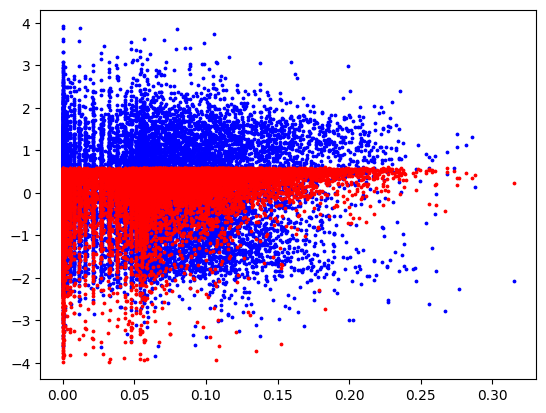

In [8]:
plt.scatter(neural_data[:,0],continuous_label[:,0] ,color='blue',s=3)
plt.scatter(neural_data[:,0],continuous_label[:,1] ,color='red',s=3)

### neural embedding model

In [9]:
# timesteps = neural_data.shape[0]
# neurons = neural_data.shape[1]
# out_dim = 2
# max_iterations = 99
# time_offsets = 10  # 0.1 s

# single_cebra_model = CEBRA(model_architecture='offset10-model',
#                            batch_size=None,  # whole dataset
#                            learning_rate=0.01,
#                            temperature_mode="auto",
#                         #    temperature=1,
#                            output_dimension=out_dim,
#                            max_iterations=max_iterations,
#                            distance='cosine',
#                            conditional='time_delta',
#                            device='cuda:0',
#                            verbose=True,
#                            time_offsets=time_offsets)



In [10]:
#  training
# for i in np.arange(5):
#     single_cebra_model.fit(neural_data, continuous_label)
    # tmp_file = Path(f'{workdir}/test/neural/cebra/', f'cebra024612_0309fast_{i+1}hr.pt')
    # single_cebra_model.save(tmp_file)
    # notify(f'cebra {i} ready')

In [11]:
# load trained model
single_cebra_model = cebra.CEBRA.load(
    f'{workdir}/test/neural/cebra/{embeddingfile}')

# ax=cebra.plot_temperature(single_cebra_model)
# ax.set_title('temperature')

In [12]:
embedding = single_cebra_model.transform(neural_data)

/home/yc/miniconda3/envs/ffneural/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


In [13]:
single_cebra_model.model_
# list(single_cebra_model.model_.net[0].parameters())

Offset10Model(
  (net): Sequential(
    (0): Conv1d(94, 32, kernel_size=(2,), stride=(1,))
    (1): GELU(approximate='none')
    (2): _Skip(
      (module): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (3): _Skip(
      (module): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (4): _Skip(
      (module): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (5): Conv1d(32, 2, kernel_size=(3,), stride=(1,))
    (6): _Norm()
    (7): Squeeze()
  )
)

# define the difference: manual designed feature

- b - e
- b - e squared

in this section, we first check and confirm the diff exist in data, by some single variable stats. showing single neuron can correlate to the diff.

then, visualize the diff in neural embedding space. showing population level correlation to diff.

## single var stats (single neuron vs task var)
not really useful, because more likely the neurons encode things in a population level. just to confirm the correlation exist
 - hard to seee. too many neurons
 - likely single neuron wont encode task vaar linearlly.

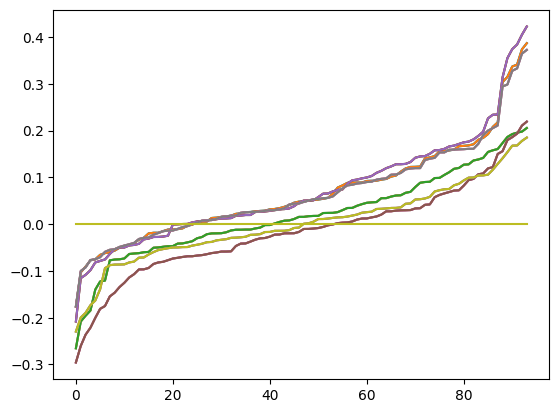

In [14]:

for tag in ['hori', 'vert']:
    for taskvar1 in range(len(var_names)):
        for taskvar2 in range(len(var_names)):
            if tag in var_names[taskvar1] and tag in var_names[taskvar2]:
                # print(tag, var_names[taskvar1], var_names[taskvar2])
                res=spearmanr(neural_data,continuous_label[:,taskvar1])[0]
                sortedcorr=sorted(res[-1][:-1])
                plt.plot(np.arange(len(sortedcorr)),sortedcorr)
plt.plot(np.arange(len(sortedcorr)), np.zeros_like(sortedcorr))
plt.show()

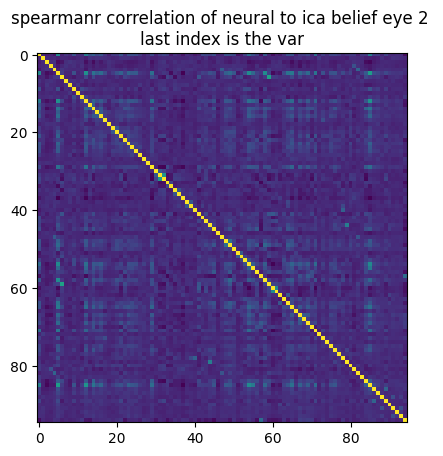

In [15]:
# neural_data.shape,continuous_label[:,taskvar1].shape
res=spearmanr(neural_data,continuous_label[:,taskvar1])[0]
plt.imshow(res)
plt.title(f'spearmanr correlation of neural to {var_names[taskvar1]} \nlast index is the var')
plt.show()
# sortedcorr=sorted(res[-1][:-1])
# plt.plot(np.arange(len(sortedcorr)),sortedcorr)
# plt.plot(np.arange(len(sortedcorr)), np.zeros_like(sortedcorr))
# plt.title(f'spearmanr correlation of neural to {var_names[taskvar1]}')

## multi var stats (neural embedding vs task var)
 - embedding may encode task var more like linearlly. 
 - only few embedding dim (intrinsic dim?) and way eaisier to see.

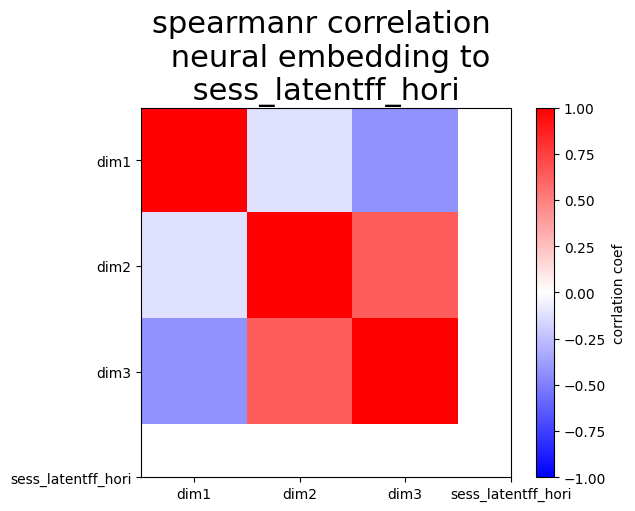

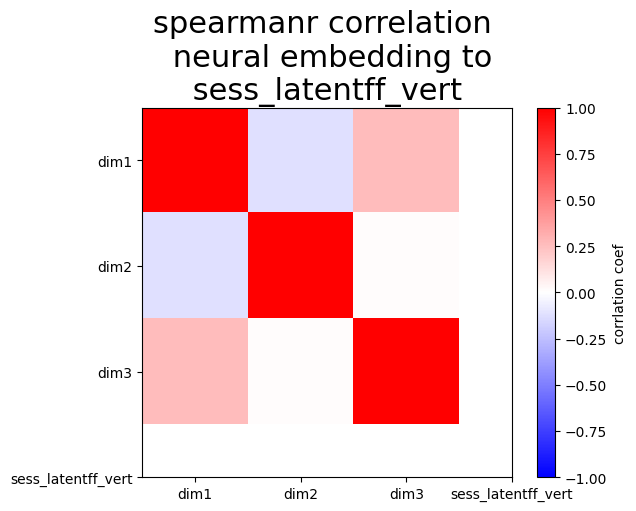

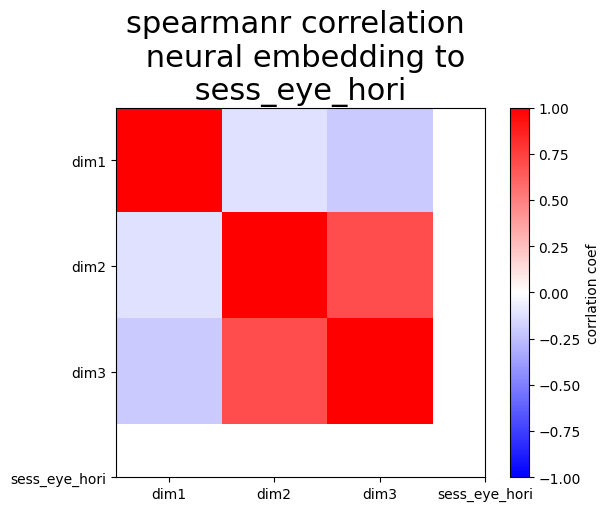

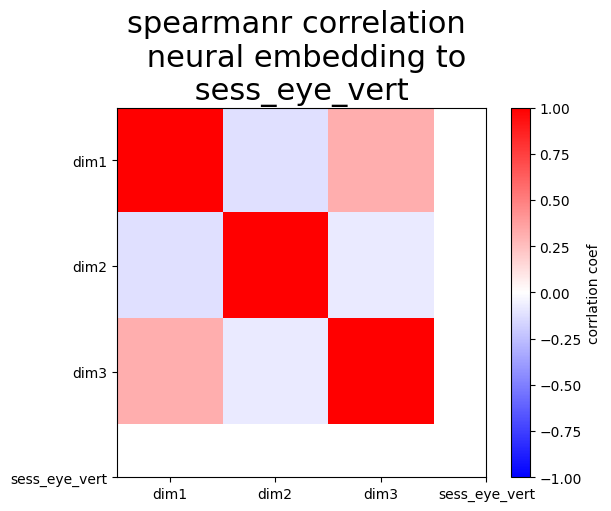

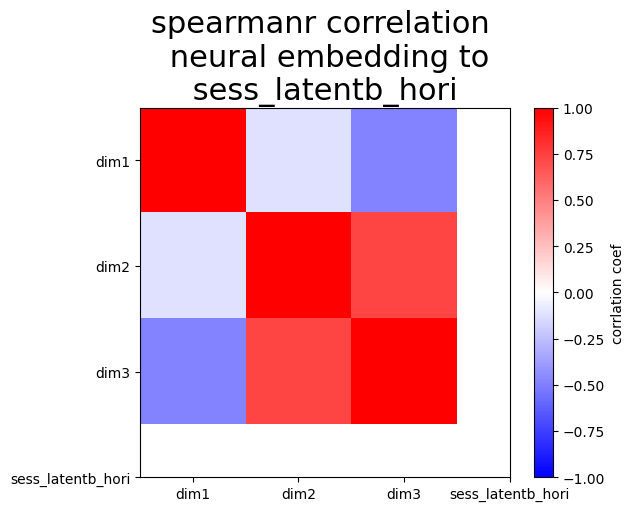

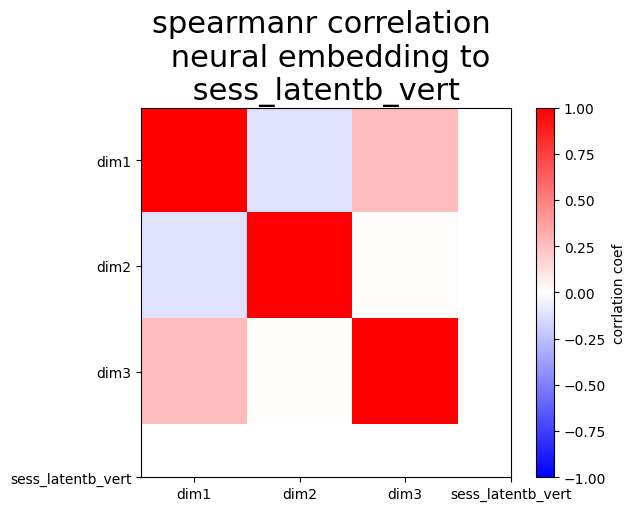

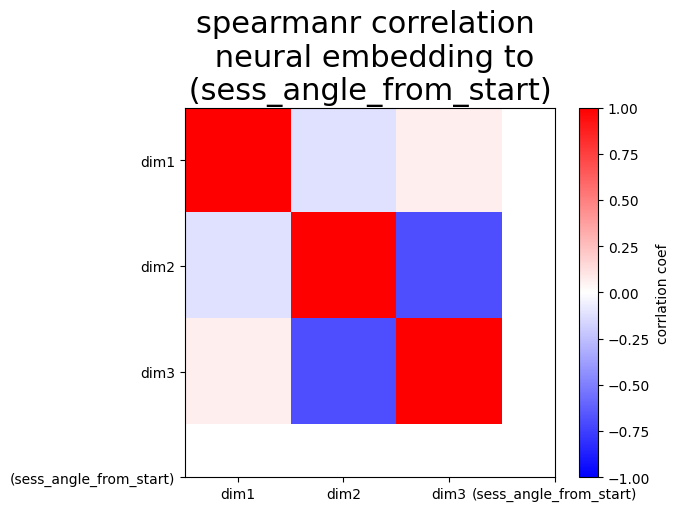

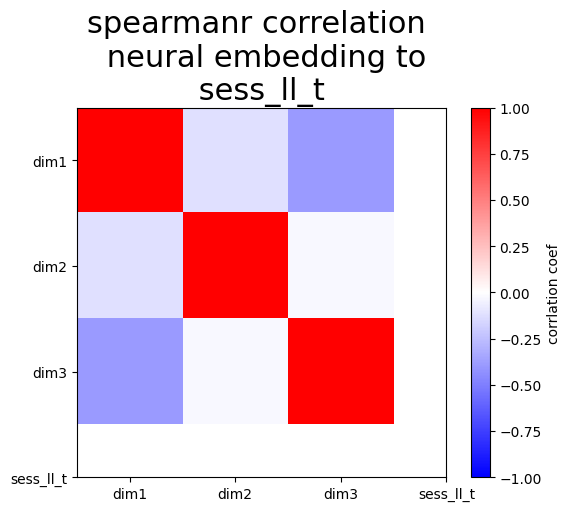

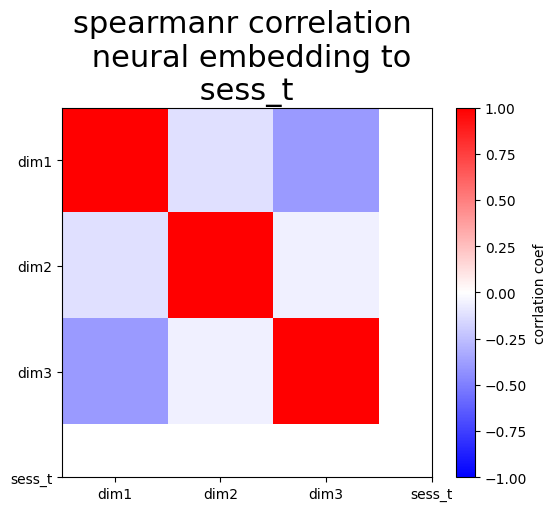

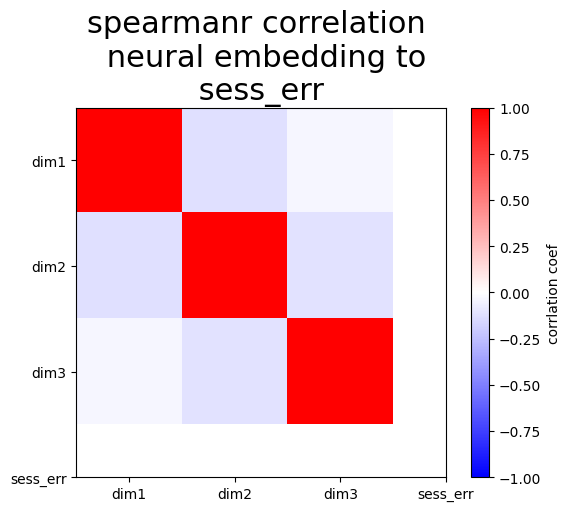

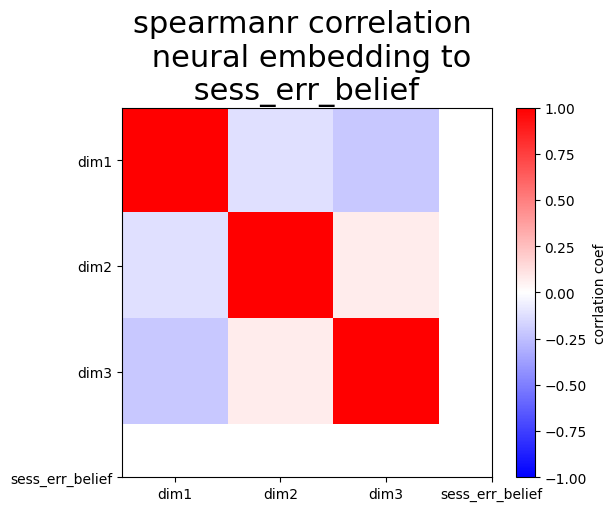

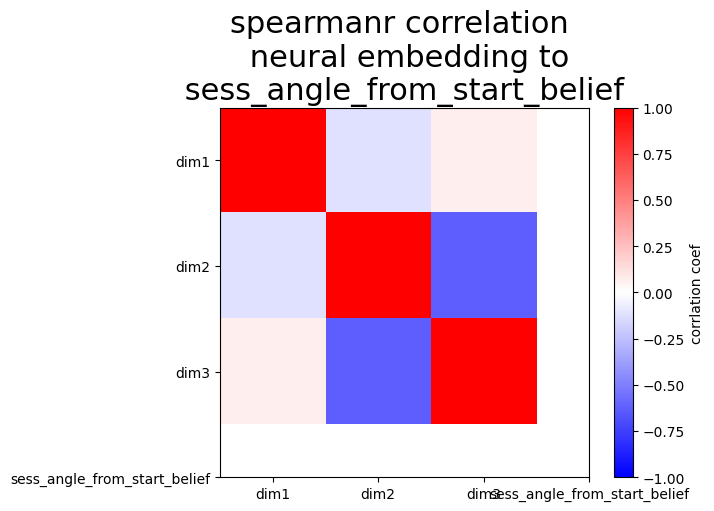

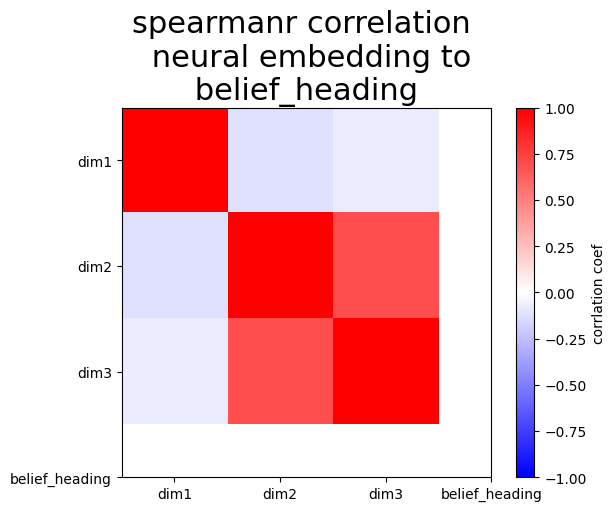

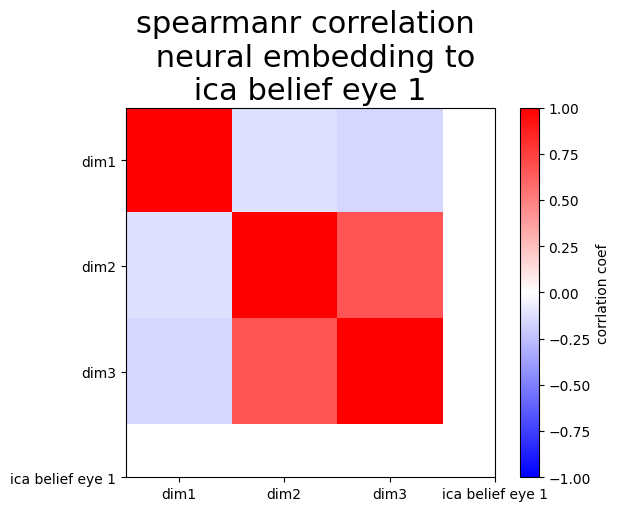

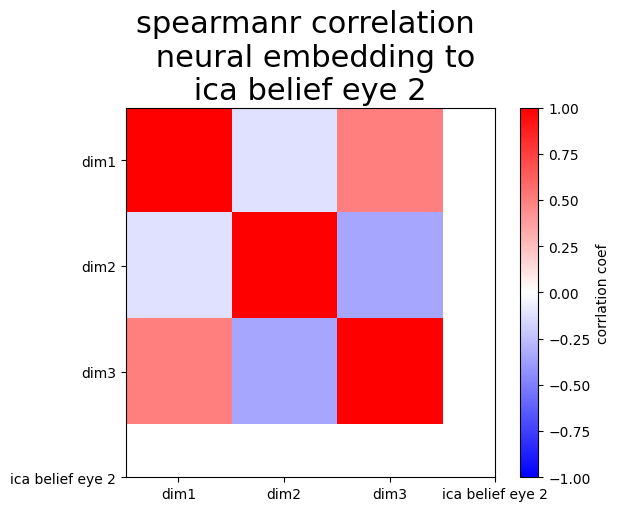

In [16]:
for taskvar1 in range(len(var_names)):
    res=spearmanr(embedding,continuous_label[:,taskvar1])[0]
    vlim=max(np.max(res), -np.min(res))
    fig,ax=plt.subplots(1,1)
    c=plt.imshow(res, cmap='bwr', vmin=-vlim, vmax=vlim)
    plt.colorbar(c, label='corrlation coef')
    plt.title(f'spearmanr correlation \n neural embedding to\n {var_names[taskvar1]} ', fontsize=22)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['dim1', 'dim2', 'dim3', f'{var_names[taskvar1]}'])
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(['dim1', 'dim2', 'dim3', f'{var_names[taskvar1]}'])
    plt.show()


## visualize the diff in 2d embedding 

we can see there is obvious gradient in the color changes. that means the neurons are encoding this difference. and in embedding space, this diff is nearly linear.

hori sess_latentff_hori 0 sess_eye_hori 2


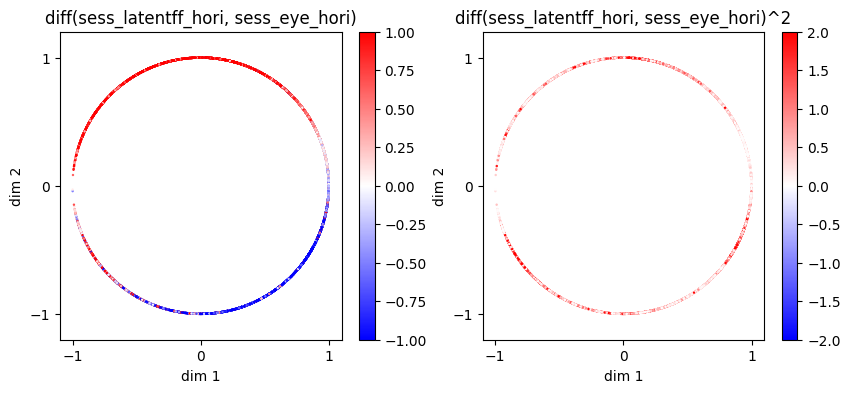

hori sess_latentff_hori 0 sess_latentb_hori 4


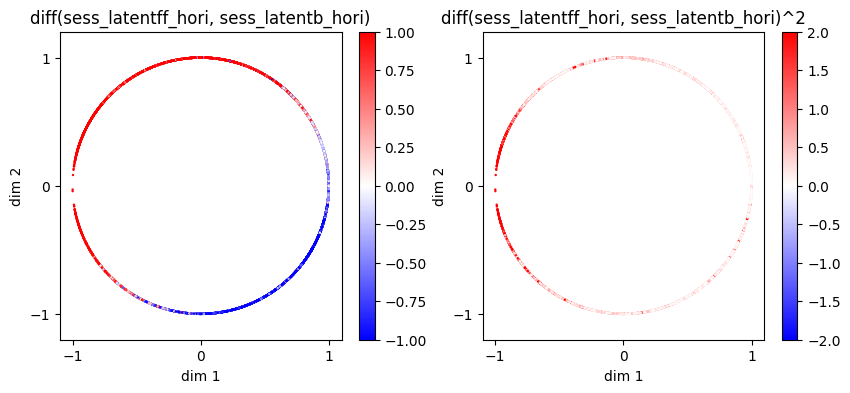

hori sess_eye_hori 2 sess_latentb_hori 4


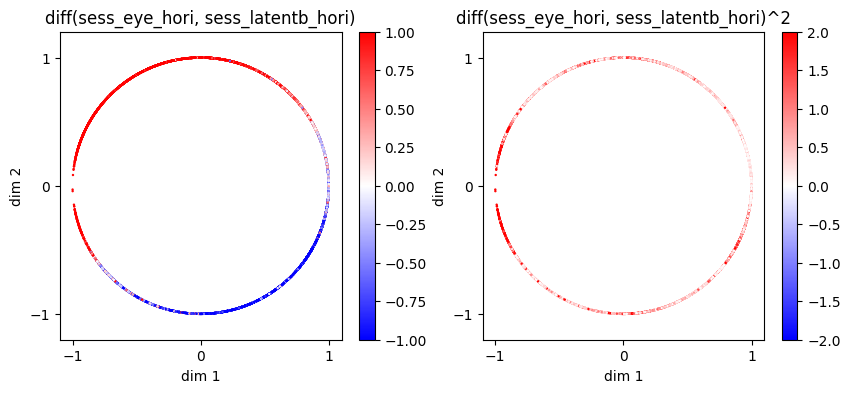

In [17]:
# generate relavent figure (eg, hori to hori)
%matplotlib inline
# for tag in ['hori', 'vert']:
for tag in ['hori']:
    for taskvar1 in range(len(var_names)):
        for taskvar2 in range(taskvar1,len(var_names)):
            if taskvar1==taskvar2: continue
            if tag in var_names[taskvar1] and tag in var_names[taskvar2]:
                print(tag, var_names[taskvar1],taskvar1, var_names[taskvar2],taskvar2)

                fig = plt.figure(figsize=(10,4))

                ax = plt.subplot(121)
                plot_embedding2d_contrast(ax, embedding, continuous_label, gray = False, beh_idx=(taskvar1,taskvar2), vmin=-1, vmax=1,contrast=lambda x, y: (x + y))
                ax.set_title(f'diff({var_names[taskvar1]}, {var_names[taskvar2]})')

                ax = plt.subplot(122)
                plot_embedding2d_contrast(ax, embedding, continuous_label, gray = False, beh_idx=(taskvar1,taskvar2),contrast=lambda x, y: (x - y)**2, vmin=0, vmax=2)
                ax.set_title(f'diff({var_names[taskvar1]}, {var_names[taskvar2]})^2')

                plt.show()

by some human check, we foudn that the eye hori vs belief firefly hori, has the best diff encoded by neurons. here it takes the entire dim 2.

note that it doesnt mean neurons do not encode other diff. just this diff is the most visible one in the first 2 mebedding dim.

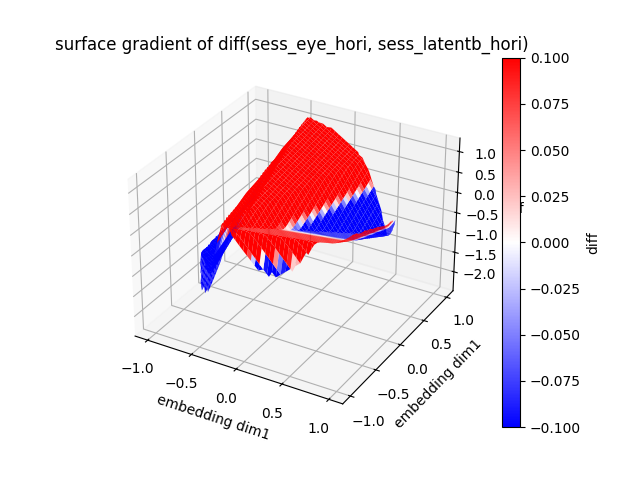

In [18]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

taskvar1,taskvar2=2,4
contrast=lambda x, y: x - y

# Example scattered data (replace with your own data)
x = embedding[:, 0]
y = embedding[:, 1]
z = contrast(continuous_label[:, taskvar1], continuous_label[:, taskvar2])

# Create a grid of points (X, Y) covering the range of your data
X, Y = np.meshgrid(np.linspace(min(x), max(x), 100),
                   np.linspace(min(y), max(y), 100))

# Interpolate the z values for the grid points using griddata
Z = griddata((x, y), z, (X, Y), method='linear')
Z_smooth = gaussian_filter(Z, sigma=0.6)
vmin, vmax=np.min(Z_smooth),np.max(Z_smooth)
vlim=max(-vmin,vmax)

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
c=ax.plot_surface(X, Y, Z_smooth, cmap='bwr', vmin=-vlim, vmax=vlim)
plt.colorbar(c, label='diff')

# Add labels and title
ax.set_xlabel('embedding dim1')
ax.set_ylabel('embedding dim1')
ax.set_zlabel('diff')
ax.set_title(f'surface gradient of diff({var_names[taskvar1]}, {var_names[taskvar2]})')

plt.show()

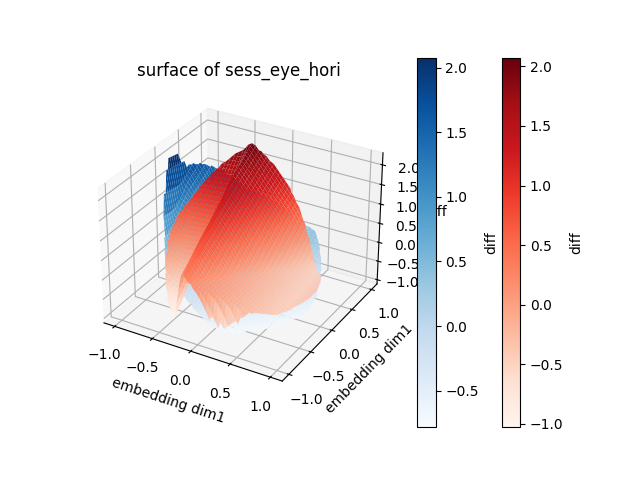

In [19]:
%matplotlib widget

taskvar1,taskvar2=2,4

# Example scattered data (replace with your own data)
x = embedding[:, 0]
y = embedding[:, 1]
z = continuous_label[:, taskvar1]

# Create a grid of points (X, Y) covering the range of your data
X, Y = np.meshgrid(np.linspace(min(x), max(x), 100),
                   np.linspace(min(y), max(y), 100))

# Interpolate the z values for the grid points using griddata
Z = griddata((x, y), z, (X, Y), method='linear')
Z_smooth = gaussian_filter(Z, sigma=1)

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
c=ax.plot_surface(X, Y, Z_smooth, cmap='Reds')
plt.colorbar(c, label='diff')

# Add labels and title
ax.set_xlabel('embedding dim1')
ax.set_ylabel('embedding dim1')
ax.set_zlabel('diff')
ax.set_title(f'surface of {var_names[taskvar1]}')


x = embedding[:, 0]
y = embedding[:, 1]
z = continuous_label[:, taskvar2]

# Create a grid of points (X, Y) covering the range of your data
X, Y = np.meshgrid(np.linspace(min(x), max(x), 100),
                   np.linspace(min(y), max(y), 100))

# Interpolate the z values for the grid points using griddata
Z = griddata((x, y), z, (X, Y), method='linear')
Z_smooth = gaussian_filter(Z, sigma=1)


c=ax.plot_surface(X, Y, Z_smooth, cmap='Blues')
plt.colorbar(c, label='diff')

# Add labels and title
ax.set_xlabel('embedding dim1')
ax.set_ylabel('embedding dim1')
ax.set_zlabel('diff')
ax.set_title(f'surface of {var_names[taskvar1]}')

plt.show()


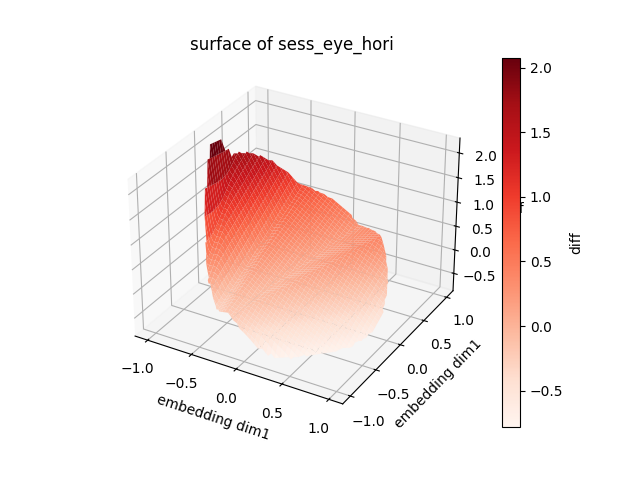

In [20]:
%matplotlib widget

taskvar1,taskvar2=2,4

# Example scattered data (replace with your own data)
x = embedding[:, 0]
y = embedding[:, 1]
z = continuous_label[:, taskvar2]

# Create a grid of points (X, Y) covering the range of your data
X, Y = np.meshgrid(np.linspace(min(x), max(x), 100),
                   np.linspace(min(y), max(y), 100))

# Interpolate the z values for the grid points using griddata
Z = griddata((x, y), z, (X, Y), method='linear')
Z_smooth = gaussian_filter(Z, sigma=1)

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
c=ax.plot_surface(X, Y, Z_smooth, cmap='Reds')
plt.colorbar(c, label='diff')

# Add labels and title
ax.set_xlabel('embedding dim1')
ax.set_ylabel('embedding dim1')
ax.set_zlabel('diff')
ax.set_title(f'surface of {var_names[taskvar1]}')

plt.show()

### conclusion
so far, we were able to show that there is more than 1 intrinsic dimension in neural codes.
neural activity encodes eye and belief, this is one dim. 
it also encodes the difference of eye and belief, this is the other dim.
so, the result support our belief is real, not just correlate with eye.


but still there could be problem. why the neurons encode the difference consistantly? 
 - we would expect the difference is small for most of the time (datapoints), because eye is tracking the belief. but here we see most of the time there is a diff. it could make sense because during previous linear fitting, we do see the eye movement data is noisy and mk are looking around, only the trend agrees with latent firefly or belief firefly. 
 - this is a result from the embedding training. in the training, we hope to keep as much info as possible. so the embedding space should be orthognal to each other. think in another way, when there is time two task do not agree, embedding shoudl repel to decrease the loss. in the end we have this orthorganl embedding spaces. then, the task var is some combination (not necessary linear. best case will be linear) in the embedding space. one thing to note is i dont think the embedding is how neuron represent information, its just eaiser for us. eg we see the neuron embeeding encodes b-e diff. actual neurons may not directly encode this, but rather encode something else thats easier for the brain, but harder for us to understand. 



# selection

### inter trial interval

we may want to select some part of trial and verify this.
eg, inter trial interval should not have a belief. how would the neural activity go?
we can get those neural activity and project to embedding space, color by eye movement.

# other

## examine the embedding in lower dim
mapping the 3d onto a 1d ring, then flatten. the best embedding should show correlation.



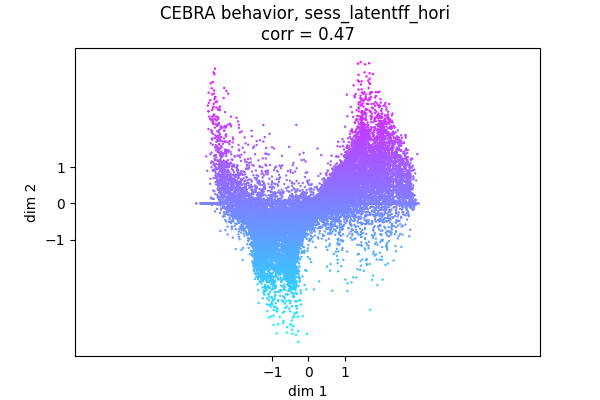

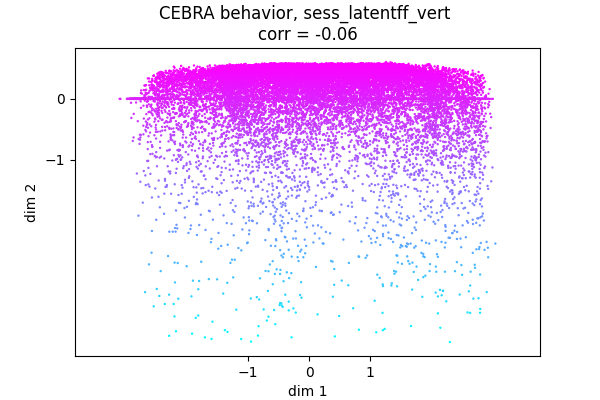

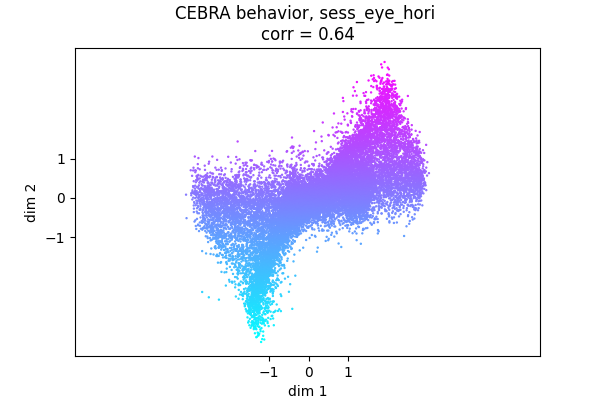

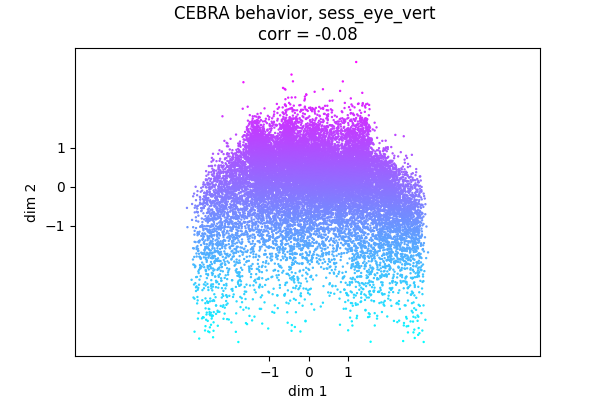

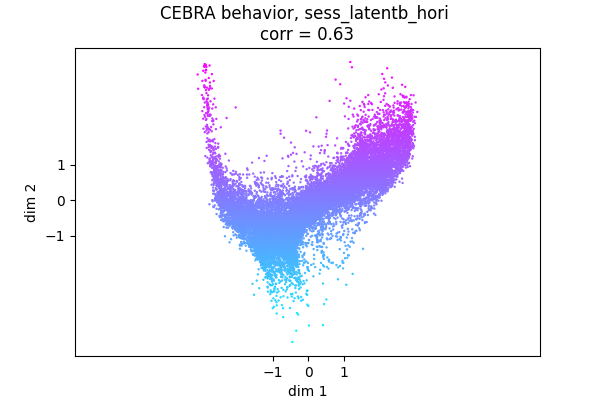

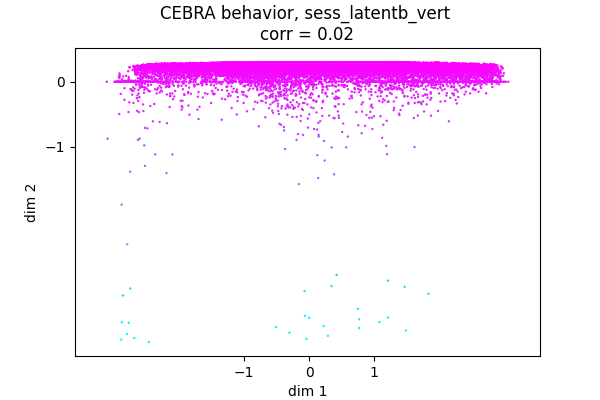

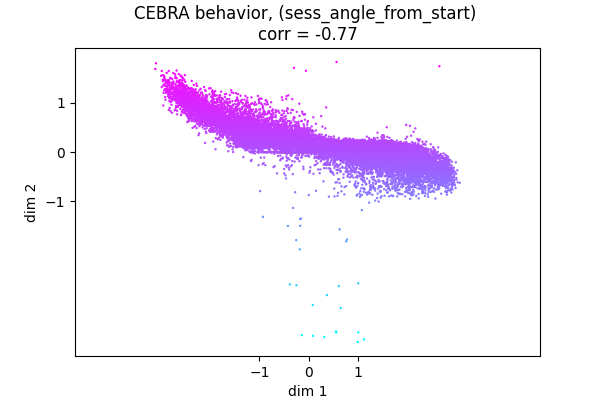

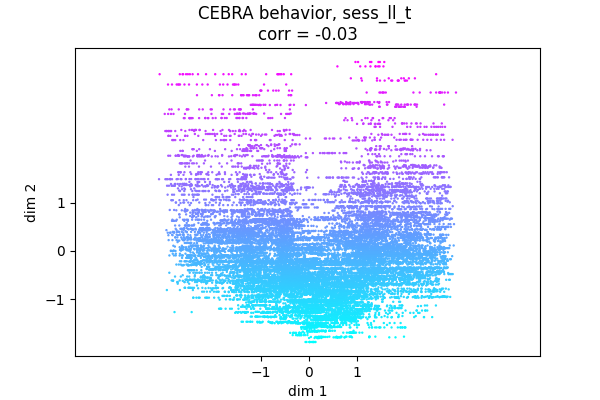

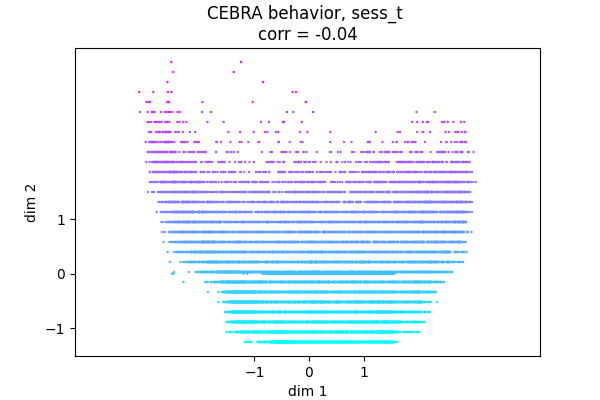

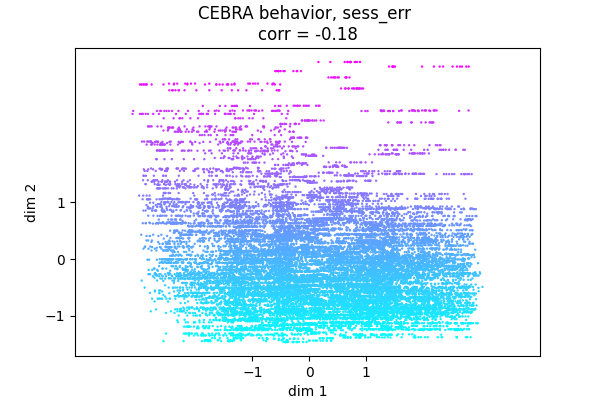

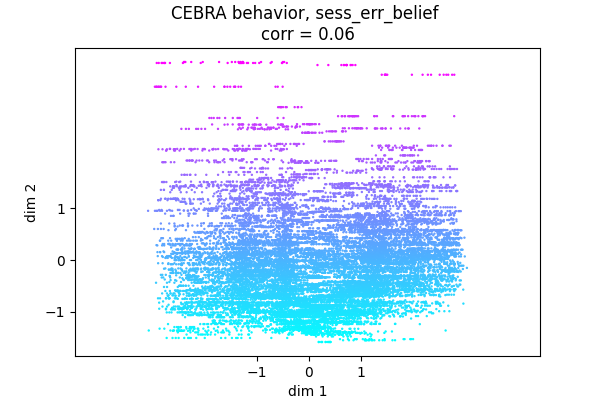

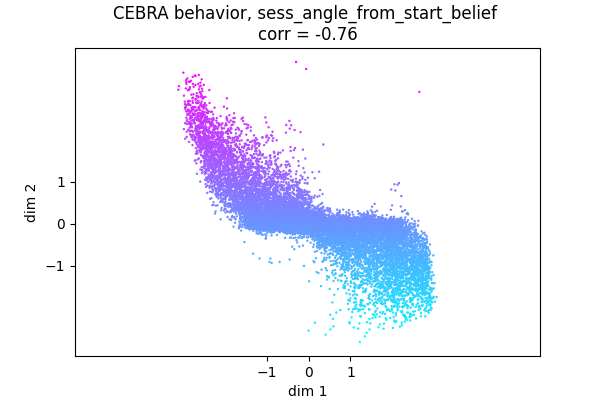

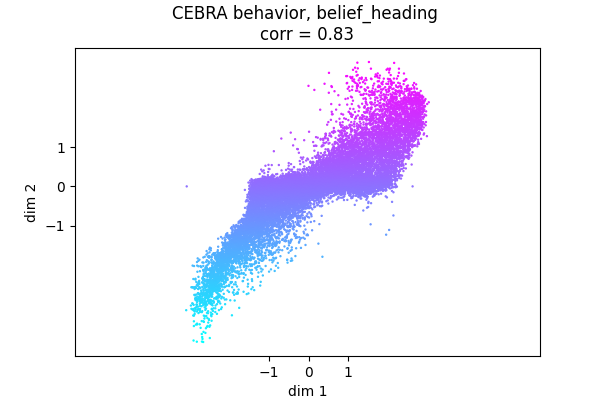

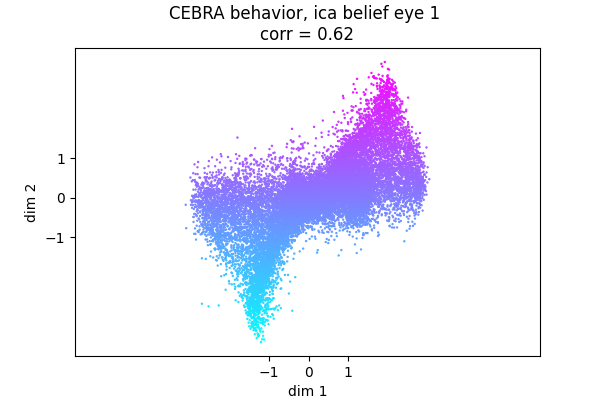

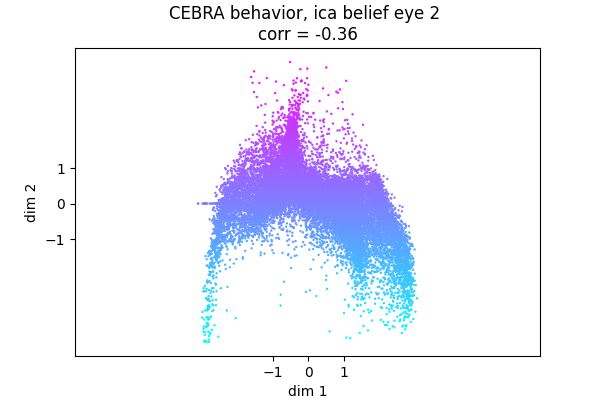

In [21]:
# %matplotlib inline

# for beh_idx in range(continuous_label.shape[1]):

#     fig = plt.figure(figsize=(6,4))
#     ax1 = plt.subplot(111)
#     ax1 = plot_embedding2d(ax1, embedding, continuous_label, beh_idx=beh_idx)
#     ax1.set_title(f'CEBRA behavior, {[beh_idx]}')
#     plt.show()


for beh_idx in range(continuous_label.shape[1]):
    fig = plt.figure(figsize=(6,4))
    ax1 = plt.subplot(111)
    ax1 = plot_embedding2d_unflold(ax1, embedding, continuous_label, beh_idx=beh_idx)
    ax1.set_title(f'CEBRA behavior, {var_names[beh_idx]} \n{ax1.get_title()}')
    plt.show()

# for beh_idx in range(continuous_label.shape[1]):
#     fig = plt.figure(figsize=(6,4))
#     ax1 = plt.subplot(111)
#     ax1 = plot_embedding2d_unflold_line(ax1, embedding, continuous_label, beh_idx=beh_idx)
#     ax1.set_title(f'CEBRA behavior, {[beh_idx]}')
#     plt.show()